Fitting 3 folds for each of 15 candidates, totalling 45 fits

📊 Validation Accuracy: 0.978125

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       168
           1       1.00      1.00      1.00      1232
           2       1.00      0.72      0.84        39
           3       0.92      0.89      0.90       134
           4       1.00      0.50      0.67         6
           5       0.95      0.90      0.93        21

    accuracy                           0.98      1600
   macro avg       0.96      0.83      0.88      1600
weighted avg       0.98      0.98      0.98      1600



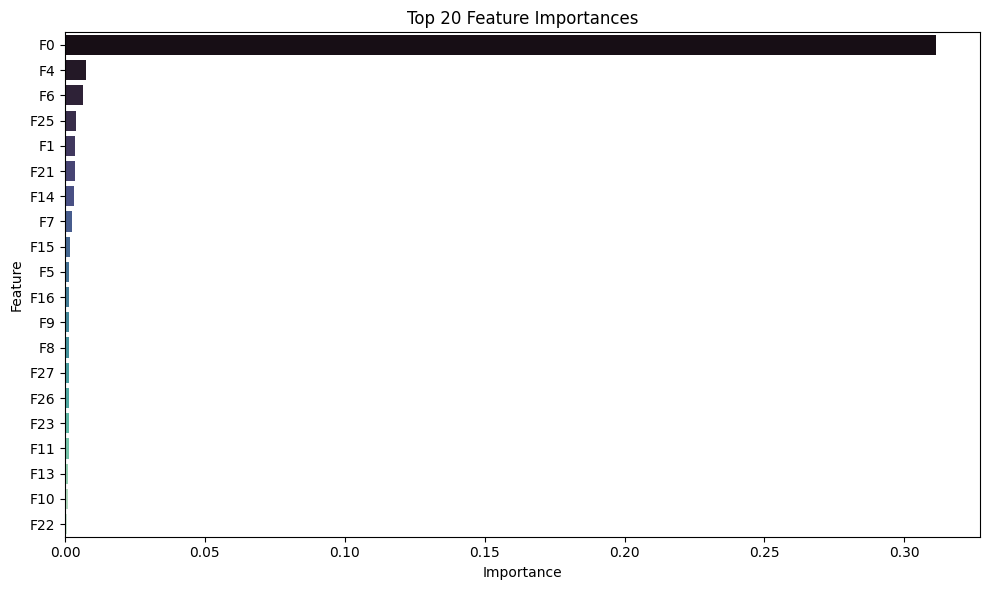

✅ submission.csv created successfully.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Load training and test data
train_df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktrain.csv")
test_df = pd.read_csv("/kaggle/input/summer-analytics-mid-hackathon/hacktest.csv")

# Preserve test IDs for final submission
test_ids = test_df['ID']

# Encode target class
le = LabelEncoder()
train_df['class'] = le.fit_transform(train_df['class'])

# Drop ID column if present
if 'ID' in train_df.columns:
    train_df.drop(columns=['ID'], inplace=True)
if 'ID' in test_df.columns:
    test_df.drop(columns=['ID'], inplace=True)

# Split train features and labels
X = train_df.drop(columns=['class'])
y = train_df['class']
X_test = test_df.copy()

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X = selector.fit_transform(X)
X_test = selector.transform(X_test)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Imputation + scaling
imputer = SimpleImputer(strategy="mean")
scaler = QuantileTransformer(output_distribution="normal")

X_train = scaler.fit_transform(imputer.fit_transform(X_train))
X_val = scaler.transform(imputer.transform(X_val))
X_test = scaler.transform(imputer.transform(X_test))

# RandomForest hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_grid,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X_train, y_train)
model = search.best_estimator_

# Evaluate
val_preds = model.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f"\n📊 Validation Accuracy: {val_acc:.6f}")
print("\nClassification Report:\n", classification_report(y_val, val_preds))

# Permutation Importance
result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
importances = pd.DataFrame({
    "Feature": [f"F{i}" for i in range(X.shape[1])],
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot top features
top_features = importances.head(20)
if top_features["Importance"].sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_features, x="Importance", y="Feature", palette="mako")
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()
else:
    print("⚠ All features have near-zero importance.")

# Predict on test data
test_preds = model.predict(X_test)
test_classes = le.inverse_transform(test_preds)

# Create submission.csv
submission = pd.DataFrame({
    "ID": test_ids,
    "class": test_classes
})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created successfully.")